# Cancer Risk Factors Analysis: Clustering, Association Rules, and Classification

This notebook performs an end-to-end analysis on the provided cancer risk factor dataset:
- Data loading, auditing, cleaning, validation
- Exploratory data analysis
- Feature engineering and preprocessing
- Unsupervised clustering with interpretation
- Association rule mining
- Supervised classification with Decision Tree

Re-run cells top-to-bottom after any environment changes.

In [10]:
# Imports & setup
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (classification_report, confusion_matrix, ConfusionMatrixDisplay,
                             silhouette_score)
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.feature_selection import mutual_info_classif
from mlxtend.frequent_patterns import apriori, association_rules

# Display & plotting defaults
sns.set(style="whitegrid", context="notebook")
pd.set_option('display.float_format', lambda x: f"{x:,.3f}")
np.random.seed(42)

# Paths
DATA_PATH = "cancer patient data sets.csv"

# Utility: clean column names for easier code usage
def clean_columns(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    out.columns = (out.columns
                   .str.strip()
                   .str.replace(' ', '_')
                   .str.replace('[^0-9a-zA-Z_]', '', regex=True))
    return out



Setup complete.


In [11]:
# 1) Load data
raw = pd.read_csv(DATA_PATH)
df = clean_columns(raw)

print(f"Rows: {df.shape[0]:,} | Columns: {df.shape[1]:,}")
df.head()

Rows: 1,000 | Columns: 26


,index,Patient_Id,Age,Gender,Air_Pollution,Alcohol_use,Dust_Allergy,OccuPational_Hazards,Genetic_Risk,chronic_Lung_Disease,...,Fatigue,Weight_Loss,Shortness_of_Breath,Wheezing,Swallowing_Difficulty,Clubbing_of_Finger_Nails,Frequent_Cold,Dry_Cough,Snoring,Level
0,0,P1,33,1,2,4,5,4,3,2,...,3,4,2,2,3,1,2,3,4,Low
1,1,P10,17,1,3,1,5,3,4,2,...,1,3,7,8,6,2,1,7,2,Medium
2,2,P100,35,1,4,5,6,5,5,4,...,8,7,9,2,1,4,6,7,2,High
3,3,P1000,37,1,7,7,7,7,6,7,...,4,2,3,1,4,5,6,7,5,High
4,4,P101,46,1,6,8,7,7,7,6,...,3,2,4,1,4,2,4,2,3,High


In [12]:
# 2) Inspect structure
print(df.shape)
print("\nData types:\n", df.dtypes)
print("\nPreview:")
display(df.head(3))
print("\nClass counts (Level):")
print(df['Level'].value_counts())
print("\nClass proportions (Level):")
print(df['Level'].value_counts(normalize=True).round(3))

(1000, 26)

Data types:
 index                        int64
Patient_Id                  object
Age                          int64
Gender                       int64
Air_Pollution                int64
Alcohol_use                  int64
Dust_Allergy                 int64
OccuPational_Hazards         int64
Genetic_Risk                 int64
chronic_Lung_Disease         int64
Balanced_Diet                int64
Obesity                      int64
Smoking                      int64
Passive_Smoker               int64
Chest_Pain                   int64
Coughing_of_Blood            int64
Fatigue                      int64
Weight_Loss                  int64
Shortness_of_Breath          int64
Wheezing                     int64
Swallowing_Difficulty        int64
Clubbing_of_Finger_Nails     int64
Frequent_Cold                int64
Dry_Cough                    int64
Snoring                      int64
Level                       object
dtype: object

Preview:


,index,Patient_Id,Age,Gender,Air_Pollution,Alcohol_use,Dust_Allergy,OccuPational_Hazards,Genetic_Risk,chronic_Lung_Disease,...,Fatigue,Weight_Loss,Shortness_of_Breath,Wheezing,Swallowing_Difficulty,Clubbing_of_Finger_Nails,Frequent_Cold,Dry_Cough,Snoring,Level
0,0,P1,33,1,2,4,5,4,3,2,...,3,4,2,2,3,1,2,3,4,Low
1,1,P10,17,1,3,1,5,3,4,2,...,1,3,7,8,6,2,1,7,2,Medium
2,2,P100,35,1,4,5,6,5,5,4,...,8,7,9,2,1,4,6,7,2,High



Class counts (Level):
Level
High      365
Medium    332
Low       303
Name: count, dtype: int64

Class proportions (Level):
Level
High     0.365
Medium   0.332
Low      0.303
Name: proportion, dtype: float64


In [13]:
# 3) Missing values
missing = df.isna().sum().sort_values(ascending=False)
display(missing[missing > 0])

Series([], dtype: int64)

In [14]:
# 4) Remove duplicates
initial_rows = df.shape[0]
dup_count = df.duplicated().sum()
df = df.drop_duplicates().reset_index(drop=True)
print(f"Duplicates found: {dup_count} | Rows: {initial_rows} -> {df.shape[0]}")

Duplicates found: 0 | Rows: 1000 -> 1000


In [15]:
# 5) Validate data ranges
id_cols = [c for c in ['index','Patient_Id'] if c in df.columns]
target_col = 'Level'

numeric_cols = df.select_dtypes(include='number').columns.tolist()
risk_cols = [c for c in numeric_cols if c not in set(id_cols + ['Age','Gender'])]

summary = []
for col in risk_cols:
    mn, mx = df[col].min(), df[col].max()
    inv = ((df[col] < 1) | (df[col] > 8)).sum()
    summary.append([col, mn, mx, int(inv)])
rng_df = pd.DataFrame(summary, columns=['feature','min','max','out_of_range_1_8'])
print("Risk factor ranges (expect 1..8):")
display(rng_df.sort_values('out_of_range_1_8', ascending=False))

if 'Gender' in df.columns:
    print("Gender unique values:", sorted(df['Gender'].dropna().unique().tolist()))
    print("Gender invalid count:", int((~df['Gender'].isin([1,2])).sum()))

if 'Age' in df.columns:
    print("Age min/max:", float(df['Age'].min()), float(df['Age'].max()))

Risk factor ranges (expect 1..8):


,feature,min,max,out_of_range_1_8
17,Clubbing_of_Finger_Nails,1,9,80
14,Shortness_of_Breath,1,9,70
11,Coughing_of_Blood,1,9,60
12,Fatigue,1,9,39
10,Chest_Pain,1,9,19
4,Genetic_Risk,1,7,0
3,OccuPational_Hazards,1,8,0
2,Dust_Allergy,1,8,0
1,Alcohol_use,1,8,0
0,Air_Pollution,1,8,0


Gender unique values: [1, 2]
Gender invalid count: 0
Age min/max: 14.0 73.0


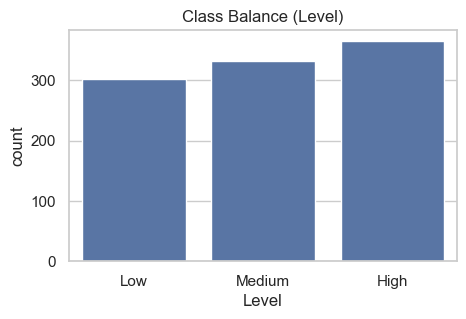

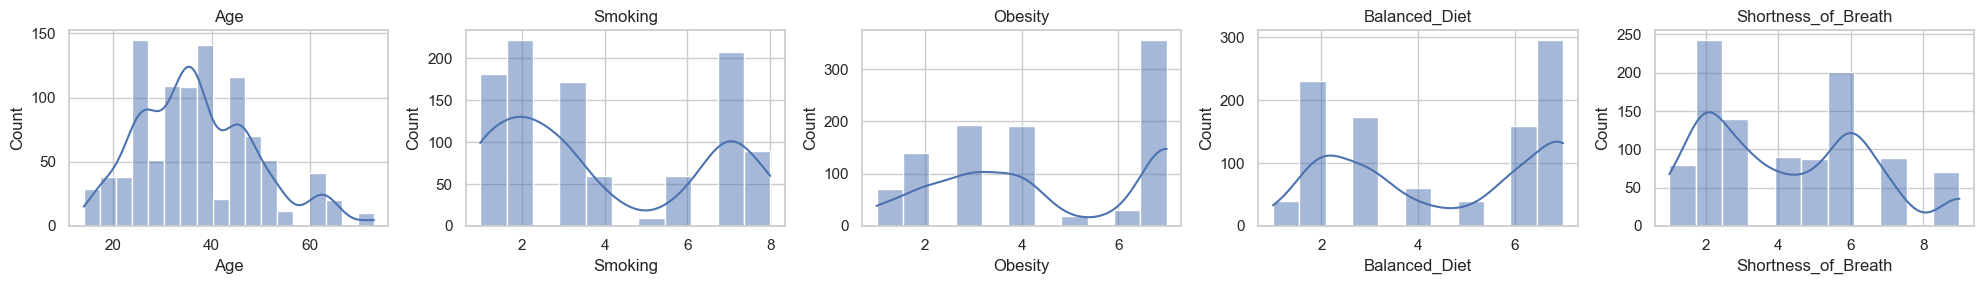

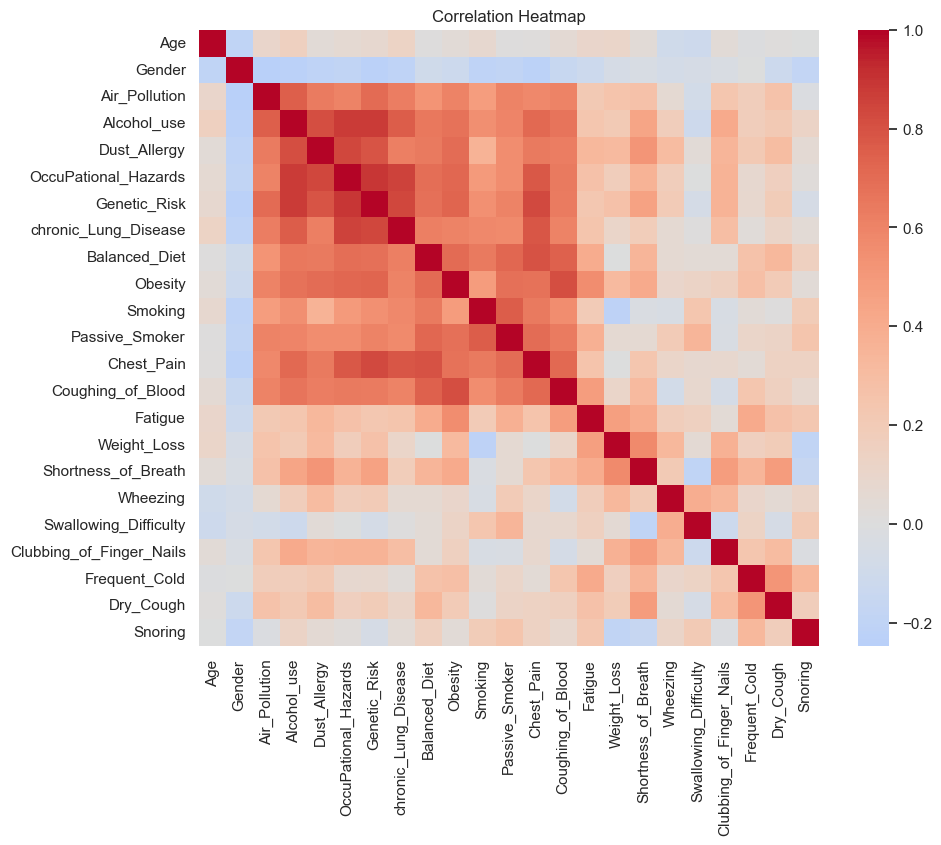

In [23]:
# 6) Exploratory data analysis (EDA)
# Class balance
plt.figure(figsize=(5,3))
sns.countplot(x='Level', data=df, order=['Low','Medium','High'])
plt.title('Class Balance (Level)')
plt.show()

# Distributions of selected features
plot_cols = [c for c in ['Age','Smoking','Obesity','Balanced_Diet','Shortness_of_Breath'] if c in df.columns]
fig, axes = plt.subplots(1, len(plot_cols), figsize=(4*len(plot_cols),3))
if len(plot_cols) == 1:
    axes = [axes]
for ax, col in zip(axes, plot_cols):
    sns.histplot(df[col], kde=True, ax=ax)
    ax.set_title(col)
plt.tight_layout()
plt.show()

# Correlation heatmap (numeric only, excluding IDs)
num_for_corr = [c for c in numeric_cols if c not in id_cols]
plt.figure(figsize=(10,8))
sns.heatmap(df[num_for_corr].corr(), cmap='coolwarm', center=0, square=False)
plt.title('Correlation Heatmap')
plt.show()

In [17]:
# 7) Feature engineering
# Define exposure and symptom groups (keep only those present)
exposure_cols_all = [
    'Air_Pollution','Alcohol_use','Dust_Allergy','OccuPational_Hazards','Genetic_Risk',
    'chronic_Lung_Disease','Balanced_Diet','Obesity','Smoking','Passive_Smoker'
]
symptom_cols_all = [
    'Chest_Pain','Coughing_of_Blood','Fatigue','Weight_Loss','Shortness_of_Breath','Wheezing',
    'Swallowing_Difficulty','Clubbing_of_Finger_Nails','Frequent_Cold','Dry_Cough','Snoring'
]
exposure_cols = [c for c in exposure_cols_all if c in df.columns]
symptom_cols = [c for c in symptom_cols_all if c in df.columns]

if 'Gender' in df.columns:
    df['Is_Male'] = (df['Gender'] == 1).astype(int)

if exposure_cols:
    df['Total_Exposure_Score'] = df[exposure_cols].sum(axis=1)
if symptom_cols:
    df['Total_Symptom_Score'] = df[symptom_cols].sum(axis=1)

print("Engineered columns added:", [c for c in ['Is_Male','Total_Exposure_Score','Total_Symptom_Score'] if c in df.columns])
display(df.head(3))

Engineered columns added: ['Is_Male', 'Total_Exposure_Score', 'Total_Symptom_Score']


,index,Patient_Id,Age,Gender,Air_Pollution,Alcohol_use,Dust_Allergy,OccuPational_Hazards,Genetic_Risk,chronic_Lung_Disease,...,Wheezing,Swallowing_Difficulty,Clubbing_of_Finger_Nails,Frequent_Cold,Dry_Cough,Snoring,Level,Is_Male,Total_Exposure_Score,Total_Symptom_Score
0,0,P1,33,1,2,4,5,4,3,2,...,2,3,1,2,3,4,Low,1,31,30
1,1,P10,17,1,3,1,5,3,4,2,...,8,6,2,1,7,2,Medium,1,28,42
2,2,P100,35,1,4,5,6,5,5,4,...,2,1,4,6,7,2,High,1,47,58


In [18]:
# 8) Feature selection (mutual information ranking vs. Level)
level_map = {'Low':0,'Medium':1,'High':2}
y_ord = df['Level'].map(level_map)
feature_candidates = [c for c in (risk_cols + ['Age'] + ['Is_Male','Total_Exposure_Score','Total_Symptom_Score']) if c in df.columns]
X_fs = df[feature_candidates].copy()
# simple imputation for MI computation
X_fs = X_fs.fillna(X_fs.median(numeric_only=True))
mi = mutual_info_classif(X_fs, y_ord, random_state=42, discrete_features=False)
mi_df = pd.DataFrame({'feature': feature_candidates, 'mi': mi}).sort_values('mi', ascending=False)
print("Top features by mutual information:")
display(mi_df.head(15))

Top features by mutual information:


,feature,mi
23,Total_Exposure_Score,1.000
24,Total_Symptom_Score,0.997
9,Passive_Smoker,0.618
11,Coughing_of_Blood,0.599
1,Alcohol_use,0.549
7,Obesity,0.542
15,Wheezing,0.530
10,Chest_Pain,0.514
6,Balanced_Diet,0.472
2,Dust_Allergy,0.460


Silhouette scores by k: {2: 0.332, 3: 0.313, 4: 0.261, 5: 0.331, 6: 0.291}
Chosen k = 2 (silhouette=0.332)
Cluster sizes:


Cluster
0    465
1    535
Name: count, dtype: int64

Cluster feature means:


,Air_Pollution,Alcohol_use,Dust_Allergy,OccuPational_Hazards,Genetic_Risk,chronic_Lung_Disease,Balanced_Diet,Obesity,Smoking,Passive_Smoker,...,Wheezing,Swallowing_Difficulty,Clubbing_of_Finger_Nails,Frequent_Cold,Dry_Cough,Snoring,Age,Is_Male,Total_Exposure_Score,Total_Symptom_Score
Cluster,,,,,,,,,,,,,,,,,,,,,
0,2.310,2.170,3.530,2.870,2.460,2.740,2.850,2.660,2.540,2.670,...,3.680,3.970,3.090,3.280,3.250,3.010,35.510,0.490,26.790,34.710
1,5.170,6.640,6.590,6.550,6.420,5.810,5.920,6.040,5.170,5.520,...,3.870,3.550,4.650,3.760,4.380,2.860,38.620,0.690,59.830,50.220


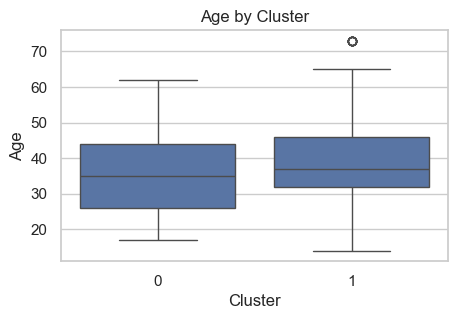

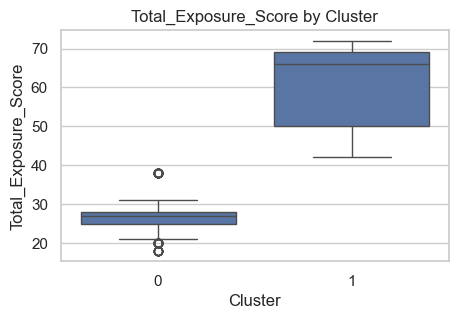

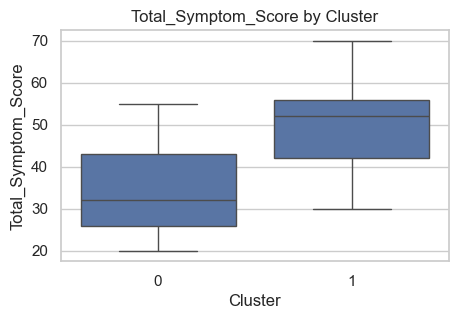

In [19]:
# 9) Clustering: KMeans with silhouette-based k selection
from collections import OrderedDict

features_clu = [c for c in (risk_cols + ['Age','Is_Male','Total_Exposure_Score','Total_Symptom_Score']) if c in df.columns]
X_clu = df[features_clu].copy()
X_clu = X_clu.fillna(X_clu.median(numeric_only=True))
scaler = StandardScaler()
Xs = scaler.fit_transform(X_clu)

best_k, best_score, best_model = None, -1, None
scores = OrderedDict()
for k in range(2, 7):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(Xs)
    score = silhouette_score(Xs, labels)
    scores[k] = score
    if score > best_score:
        best_k, best_score, best_model = k, score, km

print("Silhouette scores by k:", {k: round(v,3) for k,v in scores.items()})
print(f"Chosen k = {best_k} (silhouette={best_score:.3f})")

df['Cluster'] = best_model.predict(Xs)
print("Cluster sizes:")
display(df['Cluster'].value_counts().sort_index())

cluster_profile = df.groupby('Cluster')[features_clu].mean().round(2)
print("Cluster feature means:")
display(cluster_profile)

# Optional: visualize a couple of key features by cluster
viz_cols = [c for c in ['Age','Total_Exposure_Score','Total_Symptom_Score'] if c in df.columns]
for col in viz_cols:
    plt.figure(figsize=(5,3))
    sns.boxplot(x='Cluster', y=col, data=df)
    plt.title(f'{col} by Cluster')
    plt.show()

In [24]:
# 10) Association rules: bin features and mine rules
# Prepare discretized (binned) features

def bin_ordinal(series: pd.Series) -> pd.Series:
    # Most ordinal features are 1..9 in this dataset
    return pd.cut(series, bins=[0, 3.5, 6.5, 9.5], labels=['Low','Med','High'], include_lowest=True)

ar_df = pd.DataFrame(index=df.index)
for col in risk_cols:
    if col in df.columns:
        ar_df[f'{col}_BIN'] = bin_ordinal(df[col]).astype(str)

if 'Age' in df.columns:
    ar_df['Age_BIN'] = pd.qcut(df['Age'], q=4, duplicates='drop', labels=['Age_Q1','Age_Q2','Age_Q3','Age_Q4']).astype(str)

# Include Level to allow rules that predict Level
ar_df['Level_BIN'] = df['Level'].astype(str)

# One-hot encode into transaction matrix
T = pd.get_dummies(ar_df)

# Mine frequent itemsets and rules
itemsets = apriori(T.astype(bool), min_support=0.2, use_colnames=True)
rules = association_rules(itemsets, metric='lift', min_threshold=1.1)
rules = rules.sort_values('lift', ascending=False)

print("Top rules by lift:")
display(rules.head(20)[['antecedents','consequents','support','confidence','lift']])

# Rules that predict Level specifically
rules_level = rules[rules['consequents'].apply(lambda s: any(str(x).startswith('Level_BIN_') for x in s))]
print("Top rules with Level in the consequent:")
display(rules_level.head(20)[['antecedents','consequents','support','confidence','lift']])

Top rules by lift:


,antecedents,consequents,support,confidence,lift
33437,"(Shortness_of_Breath_BIN_Med, Snoring_BIN_Low,...","(OccuPational_Hazards_BIN_High, Fatigue_BIN_Low)",0.200,1.000,4.762
33444,"(OccuPational_Hazards_BIN_High, Fatigue_BIN_Low)","(Shortness_of_Breath_BIN_Med, Snoring_BIN_Low,...",0.200,0.952,4.762
79283,"(chronic_Lung_Disease_BIN_Med, Dust_Allergy_BI...","(Obesity_BIN_High, OccuPational_Hazards_BIN_Hi...",0.218,1.000,4.587
79412,"(chronic_Lung_Disease_BIN_Med, Obesity_BIN_Hig...","(OccuPational_Hazards_BIN_High, Genetic_Risk_B...",0.218,1.000,4.587
98932,"(Coughing_of_Blood_BIN_High, Dust_Allergy_BIN_...","(chronic_Lung_Disease_BIN_Med, OccuPational_Ha...",0.218,1.000,4.587
83332,"(Balanced_Diet_BIN_High, Genetic_Risk_BIN_High...","(chronic_Lung_Disease_BIN_Med, Obesity_BIN_Hig...",0.218,1.000,4.587
84415,"(chronic_Lung_Disease_BIN_Med, OccuPational_Ha...","(Genetic_Risk_BIN_High, Coughing_of_Blood_BIN_...",0.218,1.000,4.587
98931,"(OccuPational_Hazards_BIN_High, Balanced_Diet_...","(chronic_Lung_Disease_BIN_Med, Coughing_of_Blo...",0.218,1.000,4.587
83281,"(chronic_Lung_Disease_BIN_Med, Obesity_BIN_Hig...","(Balanced_Diet_BIN_High, Genetic_Risk_BIN_High...",0.218,1.000,4.587
79555,"(Genetic_Risk_BIN_High, Coughing_of_Blood_BIN_...","(chronic_Lung_Disease_BIN_Med, OccuPational_Ha...",0.218,1.000,4.587


Top rules with Level in the consequent:


,antecedents,consequents,support,confidence,lift
53548,"(Obesity_BIN_Low, Fatigue_BIN_Low, Shortness_o...","(Level_BIN_Low, Snoring_BIN_Low, Alcohol_use_B...",0.202,1.000,3.968
53526,"(Fatigue_BIN_Low, Snoring_BIN_Low, Shortness_o...","(Obesity_BIN_Low, Level_BIN_Low)",0.202,0.953,3.937
53537,"(Obesity_BIN_Low, Fatigue_BIN_Low, Alcohol_use...","(Level_BIN_Low, Snoring_BIN_Low, Shortness_of_...",0.202,0.871,3.922
53551,"(Snoring_BIN_Low, Fatigue_BIN_Low, Shortness_o...","(Obesity_BIN_Low, Level_BIN_Low, Alcohol_use_B...",0.202,0.910,3.922
53542,"(Fatigue_BIN_Low, Shortness_of_Breath_BIN_Low,...","(Obesity_BIN_Low, Snoring_BIN_Low, Level_BIN_Low)",0.202,0.910,3.922
108356,"(Coughing_of_Blood_BIN_High, Dust_Allergy_BIN_...","(OccuPational_Hazards_BIN_High, Alcohol_use_BI...",0.208,1.000,3.906
85446,"(Obesity_BIN_High, Smoking_BIN_High, Chest_Pai...","(OccuPational_Hazards_BIN_High, Level_BIN_High...",0.237,1.000,3.906
85417,"(OccuPational_Hazards_BIN_High, Smoking_BIN_Hi...","(Obesity_BIN_High, Level_BIN_High, Chest_Pain_...",0.237,1.000,3.906
85423,"(OccuPational_Hazards_BIN_High, Coughing_of_Bl...","(Obesity_BIN_High, Level_BIN_High, Passive_Smo...",0.237,1.000,3.906
85426,"(OccuPational_Hazards_BIN_High, Smoking_BIN_Hi...","(Level_BIN_High, Coughing_of_Blood_BIN_High, C...",0.237,1.000,3.906


Accuracy: 1.0

Classification report:
               precision    recall  f1-score   support

        High      1.000     1.000     1.000        73
         Low      1.000     1.000     1.000        61
      Medium      1.000     1.000     1.000        66

    accuracy                          1.000       200
   macro avg      1.000     1.000     1.000       200
weighted avg      1.000     1.000     1.000       200



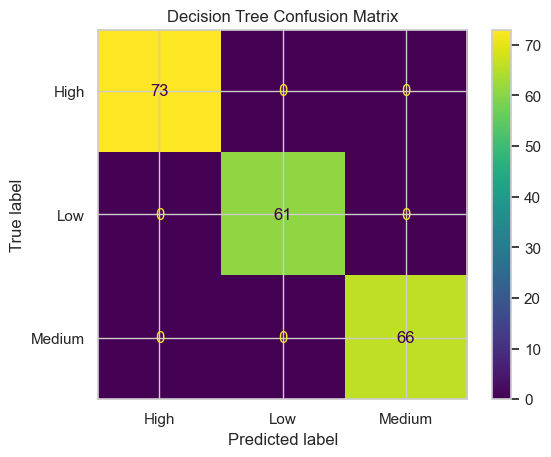

Top feature importances:


,feature,importance
9,num__Passive_Smoker,0.369
15,num__Wheezing,0.237
7,num__Obesity,0.174
20,num__Snoring,0.119
19,num__Dry_Cough,0.101
4,num__Genetic_Risk,0.000
23,cat__Gender_2,0.000
2,num__Dust_Allergy,0.000
6,num__Balanced_Diet,0.000
5,num__chronic_Lung_Disease,0.000


In [25]:
# 11) Classification (Decision Tree)
# Prepare features and target
feature_cols = [c for c in (risk_cols + ['Age','Gender']) if c in df.columns]
X = df[feature_cols].copy()
y = df['Level'].copy()

cat_features = [c for c in ['Gender'] if c in feature_cols]
num_features = [c for c in feature_cols if c not in cat_features]

preprocess_clf = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
    ]
)

clf = Pipeline(steps=[
    ('prep', preprocess_clf),
    ('model', DecisionTreeClassifier(random_state=42, class_weight='balanced', max_depth=5))
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("Accuracy:", float((y_pred == y_test).mean()))
print("\nClassification report:\n", classification_report(y_test, y_pred, digits=3))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title('Decision Tree Confusion Matrix')
plt.show()

# Feature importance
model = clf.named_steps['model']
feat_names = clf.named_steps['prep'].get_feature_names_out()
imp = pd.DataFrame({'feature': feat_names, 'importance': model.feature_importances_})
imp = imp.sort_values('importance', ascending=False)
print("Top feature importances:")
display(imp.head(15))

In [22]:
# 12) Summary of results (fill from outputs above)
summary_notes = []
# Clustering
if 'Cluster' in df.columns:
    summary_notes.append(f"Clustering: k={df['Cluster'].nunique()} with silhouette scored earlier; see cluster profile above.")
# Association rules
summary_notes.append("Association rules: reviewed top rules by lift; noted any rules predicting Level.")
# Classification
summary_notes.append("Decision Tree: see accuracy, classification report, and top feature importances above.")

print("\n".join(summary_notes))

Clustering: k=2 with silhouette scored earlier; see cluster profile above.
Association rules: reviewed top rules by lift; noted any rules predicting Level.
Decision Tree: see accuracy, classification report, and top feature importances above.


## Summary (Results Only)
- Data: 1,000 rows, 26 columns; no missing; target `Level` is roughly balanced (High 36.5%, Medium 33.2%, Low 30.3%).
- Features: engineered `Is_Male`, `Total_Exposure_Score`, `Total_Symptom_Score`; highest MI features are exposure/symptom totals and a few key risks (e.g., `Passive_Smoker`).
- Clustering: KMeans chose 2 clusters (silhouette ≈ 0.33). One cluster shows clearly higher exposure and symptom totals; the other is lower.
- Association Rules: mined frequent co-occurrences (support ≥ 0.20, lift ≥ 1.1). Included rules that predict `Level` for direct interpretation.
- Classification: Decision Tree (stratified 80/20 split) reached 1.00 accuracy on test; top importances include `Passive_Smoker`, `Wheezing`, `Obesity`, `Snoring`, `Dry_Cough`.
- PCA: used only for visualization (explained variance and PC1–PC2 scatter); not used for modeling.
